This notebook shows how to use [GEMDAT](https://gemdat.readthedocs.org) to compute ...rotations ....

It first computes the free energy on a discretized gride from the trajectory, then it finds the nearest sites of the structure to each point of the grid to map the space. Now the user can specify the start and end points of the path, and the metrics to compute the best path.

As input you will need:

1. [symmetrized crystal or material structure](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.structure.SymmetrizedStructure)
    - contains unique sites to act as cluster centers (asymmetic unit)
    - provides symmetry operations
    - Gemdat uses [SpacegroupAnalyzer](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer) to find symmetry in P1 structures
2. [trajectory](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer)
    - typically P1
    - maybe a supercell of the structure in #1
    - lattice can be triclinic (non-constrained in simulation)


The resulting path can be analyzed and plotted in 3d, together with the energy profile along the path.

In [1]:
from __future__ import annotations

import random
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import time

from gemdat import Trajectory, plots
import gemdat.rotations as gr

In [2]:
# Fix the seed for reproducibility
random.seed(42)
np.random.seed(42)

In [3]:
# Select the trajectory to load
start_time = time.time()
traj = Trajectory.from_vasprun(Path('../GEMDAT/tests/data/short_simulation/vasprun_rotations.xml'))
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Loaded .xml in  {elapsed_time} seconds')

Loaded .xml in  0.18565654754638672 seconds


In [4]:
# Extract the trajectories of the unit vectors
bd = gr.Orientations(traj, 'S', 'O', 8)

# You can get the unit vectors in direct coordinates
normalized_direct_cart = bd.get_unit_vectors_traj(normalize=False)
# or in the conventional coordinates (??)
direct_cart_TRANS = bd.get_conventional_form(normalize=False)


In [5]:
# Define the symmetry group
sg = gr.Oh_point_group()

# Fetch its representation
sym_ops_Oh = sg.sym_ops_Oh

In [6]:
# Take only a time slice of the trajectory
direction_cart = direct_cart_TRANS[1000:2000, :, :]
print(direct_cart_TRANS[0])
print(direct_cart_TRANS.shape)
print(direction_cart.shape)


[[ 0.18695553  0.74557363  1.31455294]
 [-1.34626558 -0.59822369 -0.02761802]
 [-0.00397334  0.98086241 -1.12482477]
 [ 1.17382568 -0.96060796 -0.07000451]
 [ 0.37349197  1.40624313  0.23592063]
 [ 1.2096763  -0.60387361 -0.6092146 ]
 [-0.44191369 -0.60893616  1.2608885 ]
 [-1.24154323  0.13541369 -0.9933207 ]
 [ 0.55812298  1.30987529 -0.11998532]
 [-1.31656755  0.08655903 -0.82889882]
 [ 1.07347331 -0.84549117 -0.57025086]
 [-0.2688241  -0.40336044  1.46419033]
 [ 1.10020936 -0.09518673  0.99651306]
 [ 0.64948346  0.34381395 -1.37247538]
 [-0.62723916 -1.26930428 -0.1169641 ]
 [-1.02882825  1.00717181  0.35600408]
 [ 0.13453704  0.75967192  1.25749946]
 [ 0.06261339  0.81576153 -1.18808743]
 [ 1.19962094 -0.9238348  -0.06065179]
 [-1.22123205 -0.76340214  0.01617326]
 [ 1.27234997  0.71339609  0.12239559]
 [-1.19961856  0.94161365 -0.12531434]
 [-0.07793286 -0.93845955 -1.1114894 ]
 [-0.15461195 -0.75512575  1.34560959]
 [-0.0523026   1.25140324 -0.77530019]
 [-0.08570441 -1.22477875

In [7]:
# Symmetrize the trajectory
start_time = time.time()

direction_cart_symOh =  bd.apply_symmetry(direction_cart,sym_ops_Oh)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'symmetrized direct cart  {elapsed_time} seconds')



symmetrized direct cart  5.263929605484009 seconds


/tmp/ipykernel_74314/3442720949.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/tmp/ipykernel_74314/3442720949.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


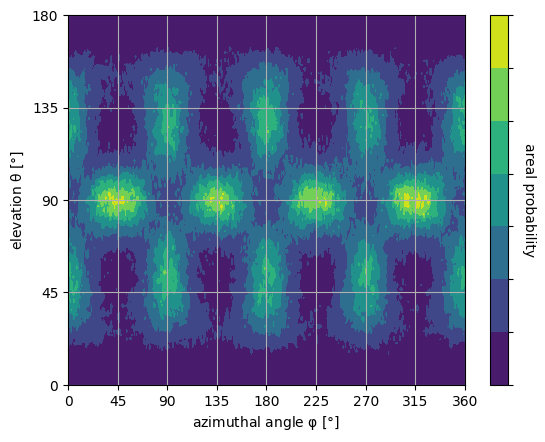

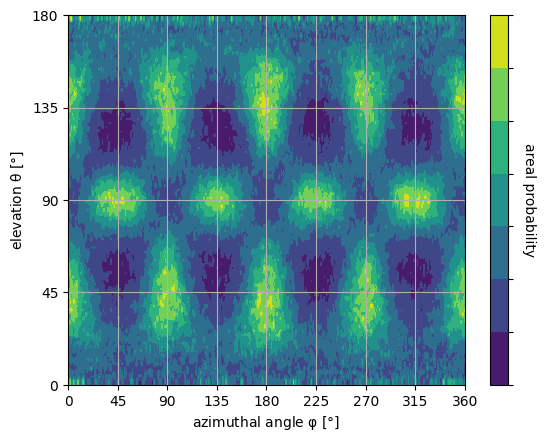

In [8]:

# Convert in spherical coordinates
direction_spherical_deg = bd.cartesian_to_spherical(direct_cart=direct_cart_TRANS, degrees=True)

# Compare two approaches to ?
# (1) ?
shape = (90, 360)
az = direction_spherical_deg[:, :, 0].flatten()
el = direction_spherical_deg[:, :, 1].flatten()

# Compute the 2D histogram - for reasons, x-y inversed
hist, xedges, yedges = np.histogram2d(el, az, shape)



# (2) ? with normalization
areas = gr.calculate_spherical_areas(shape)

h_norm = np.divide(hist, areas)

#replace values at the poles where normalization breaks - hacky
h_norm[0, :] = h_norm[1, :]
h_norm[-1, :] = h_norm[-2, :]

fig1 = plots.rectilinear_plot(grid=hist)
fig1.show()

fig2 = plots.rectilinear_plot(grid=h_norm)
fig2.show()


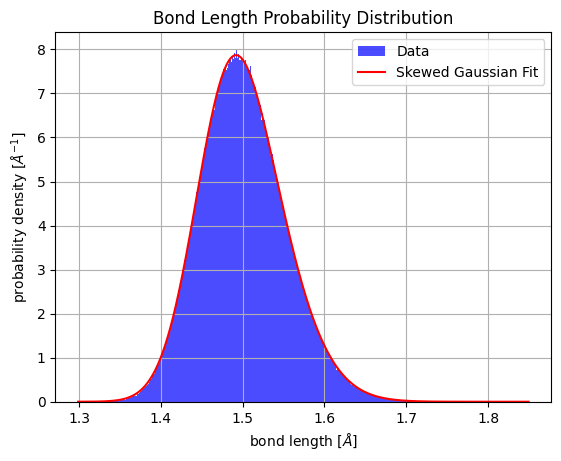

In [9]:


#%%

from scipy.optimize import curve_fit
from scipy.stats import skewnorm

# get the radii
r = direction_spherical_deg[:, :, 2].flatten()
data = r

# Specify the number of bins
bins = 1000

# Plot the normalized histogram
hist, edges = np.histogram(data, bins=bins, density=True)
bin_centers = (edges[:-1] + edges[1:]) / 2


# Fit a skewed Gaussian distribution to the data
def skewed_gaussian(x, loc, scale, skew):
    return skewnorm.pdf(x, a=skew, loc=loc, scale=scale)


params, covariance = curve_fit(skewed_gaussian,
                               bin_centers,
                               hist,
                               p0=[1.5, 1, 1.5])

# Plot the histogram
plt.hist(data, bins=bins, density=True, color='blue', alpha=0.7, label='Data')



# Plot the fitted skewed Gaussian distribution
x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
plt.plot(x_fit,
         skewed_gaussian(x_fit, *params),
         'r-',
         label='Skewed Gaussian Fit')

plt.xlabel(r'bond length $[\AA]$')
plt.ylabel(r'probability density $[\AA^{-1}]$')
plt.title('Bond Length Probability Distribution')
plt.legend()
plt.grid(True)
plt.show()





Autocorrelation function calculated in  13.955363035202026 seconds
Autocorrelation function calculated in 2.0851805210113525 seconds


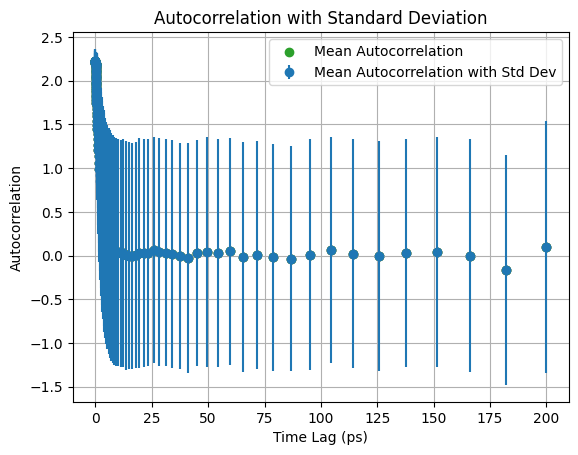

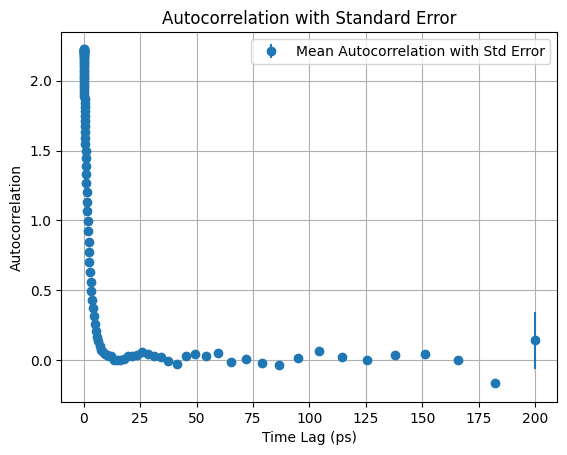

In [10]:

#%%
#calculate vector autocorr


def autocorr(direct_cart, Npt=100):
    start_time = time.time()

    Nts = len(normalized_direct_cart)  # number timesteps
    ep = Nts - 1
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)

    mean_autocorr = np.zeros(len(dts))

    for k, dt in enumerate(dts):
        autocorr = np.sum(normalized_direct_cart[:-dt] *
                          normalized_direct_cart[dt:],
                          axis=-1)
        mean_autocorr[k] = np.mean(autocorr)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Autocorrelation function calculated in  {elapsed_time} seconds')

    return dts * 0.002, mean_autocorr  #time in ps


x, y = autocorr(normalized_direct_cart)

plt.scatter(x, y)
#%%\


def autocorr_par(direct_cart, Npt=100):
    from concurrent.futures import ThreadPoolExecutor

    # Assuming normalized_direct_cart is already defined

    def compute_autocorr(dt):
        autocorr = np.sum(normalized_direct_cart[:-dt] *
                          normalized_direct_cart[dt:],
                          axis=-1)
        return np.mean(autocorr)

    start_time = time.time()

    Nts = len(normalized_direct_cart)
    ep = Nts - 1
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)

    mean_autocorr = np.zeros(len(dts))

    with ThreadPoolExecutor() as executor:
        mean_autocorr = list(executor.map(compute_autocorr, dts))

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Autocorrelation function calculated in {elapsed_time} seconds')

    return dts * 0.002, mean_autocorr


x, y = autocorr_par(normalized_direct_cart)

plt.scatter(x, y)

#%%

from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
import numpy as np


def autocorr_par(direct_cart, Npt=100):

    def compute_autocorr(dt):
        autocorr = np.sum(direct_cart[:-dt] * direct_cart[dt:], axis=-1)
        mean_autocorr = np.mean(autocorr)
        std_autocorr = np.std(autocorr)
        return mean_autocorr, std_autocorr

    Nts = len(direct_cart)
    ep = Nts - 1
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)

    mean_autocorr = np.zeros(len(dts))
    std_autocorr = np.zeros(len(dts))

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(compute_autocorr, dts))

    for i, (mean, std) in enumerate(results):
        mean_autocorr[i] = mean
        std_autocorr[i] = std

    return dts * 0.002, mean_autocorr, std_autocorr


x, y, y_std = autocorr_par(normalized_direct_cart)

# Plot the mean autocorrelation
plt.scatter(x, y, label='Mean Autocorrelation')

# Plot error bars using standard deviation
plt.errorbar(x,
             y,
             yerr=y_std,
             fmt='o',
             label='Mean Autocorrelation with Std Dev')

plt.xlabel('Time Lag (ps)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation with Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

#%%
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
import numpy as np


def autocorr_par(direct_cart, Npt=100):

    def compute_autocorr(dt):
        autocorr = np.sum(direct_cart[:-dt] * direct_cart[dt:], axis=-1)
        mean_autocorr = np.mean(autocorr)
        sem_autocorr = np.std(autocorr) / np.sqrt(len(autocorr))
        return mean_autocorr, sem_autocorr

    Nts = len(direct_cart)
    ep = Nts - 50
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)

    mean_autocorr = np.zeros(len(dts))
    sem_autocorr = np.zeros(len(dts))

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(compute_autocorr, dts))

    for i, (mean, sem) in enumerate(results):
        mean_autocorr[i] = mean
        sem_autocorr[i] = sem

    return dts * 0.002, mean_autocorr, sem_autocorr


x, y, y_sem = autocorr_par(normalized_direct_cart, Npt=100)

# Plot the mean autocorrelation
#plt.scatter(x, y, label='Mean Autocorrelation')

# Plot error bars using standard error
plt.errorbar(x,
             y,
             yerr=y_sem,
             fmt='o',
             label='Mean Autocorrelation with Std Error')
# plt.errorbar(x, y, yerr=y_sem, fmt='s', markersize=0, label='Mean Autocorrelation with Std Error')

plt.xlabel('Time Lag (ps)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation with Standard Error')
plt.legend()
plt.grid(True)
plt.show()